# Mar-?-2021 (baselines)

**Motivation**: Overlapping communities.<br>

In [1]:
# HIDE CODE


# generic imports
import re
import os
import sys
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import nibabel as nib
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from os.path import join as pjoin
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import patches
from matplotlib import cm
import seaborn as sns
sns.set_style('white')

# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from tqdm.notebook import tqdm

# nx imports
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.classes.function import density

# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length
from networkx.algorithms.smallworld import sigma, omega

# Louvain
import community as community_louvain


# fix random stete
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

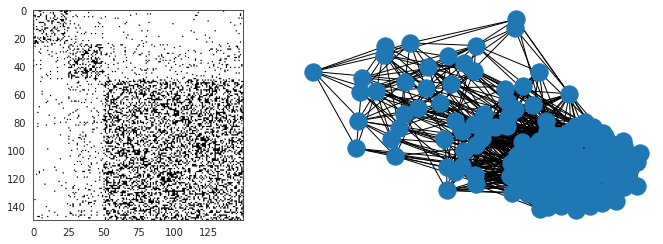

In [165]:
sizes = [25, 25, 100]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
g = nx.stochastic_block_model(
    sizes=sizes,
    p=probs,
    seed=RANDOM_STATE,
)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

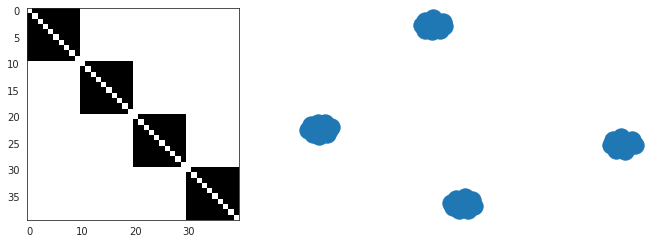

In [54]:
g = nx.caveman_graph(4, 10)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

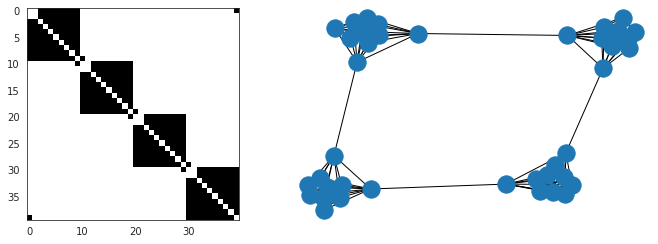

In [52]:
g = nx.connected_caveman_graph(4, 10)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

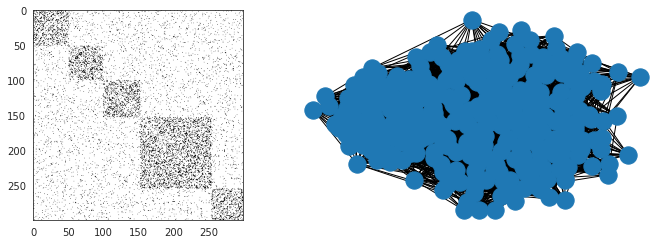

In [86]:
g = nx.gaussian_random_partition_graph(n=300, s=60, v=1, p_in=0.3, p_out=0.05, seed=RANDOM_STATE)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

## LFR

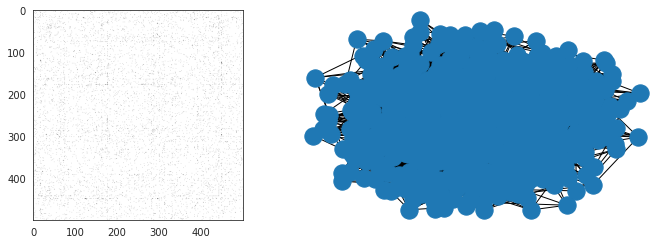

In [528]:
g = nx.LFR_benchmark_graph(
    n=500,
    tau1=3,
    tau2=1.7,
    mu=0.3,
    min_degree=6,
    min_community=50,
    # max_community=15,
    max_iters=50,
    seed=RANDOM_STATE,
)
a = nx.adjacency_matrix(g).toarray()

plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.imshow(a, cmap='Greys')
plt.subplot(122)
nx.draw(g)
plt.tight_layout()
plt.show()

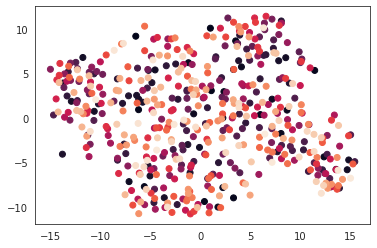

In [529]:
from karateclub import DeepWalk

model = DeepWalk(dimensions=32, learning_rate=0.01)
model.fit(g)
embedding = model.get_embedding()

import numpy as np
from sklearn.manifold import TSNE
x = TSNE(n_components=2, perplexity=50).fit_transform(embedding)

plt.scatter(x[:, 0], x[:, 1], c=range(len(x)))

In [530]:
communities = {frozenset(g.nodes[v]["community"]) for v in g}
nx.algorithms.community.community_utils.is_partition(g, communities)

True

In [531]:
communities_true = {idx: list(comm) for idx, comm in enumerate(communities)}
partition_true = {v: next(filter(lambda x: v in x[1], communities_true.items()))[0] for v in g}

len(communities_true)

7

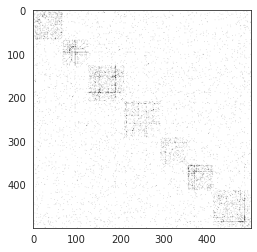

In [532]:
comm_indxs = np.concatenate(list(communities_true.values()))
plt.imshow(a[comm_indxs][:, comm_indxs], cmap='Greys')

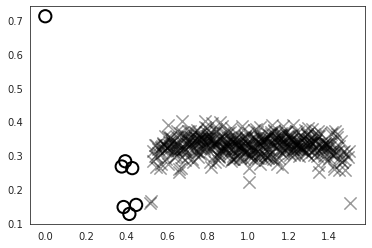

In [534]:
w, v = np.linalg.eigh(nx.normalized_laplacian_matrix(g).toarray())
ipr = 1 / np.power(v, 4).sum(0)
ipr /= len(ipr)
sort_indxs = np.argsort(w)

num_comm = len(communities_true)
plt.scatter(
    w[sort_indxs[num_comm:]], ipr[sort_indxs[num_comm:]],
    marker='x', color='k', s=150, alpha=0.4,
)
plt.scatter(
    w[sort_indxs[:num_comm]], ipr[sort_indxs[:num_comm]],
    marker='o', edgecolors='k', lw=2, color='none', s=150,
)

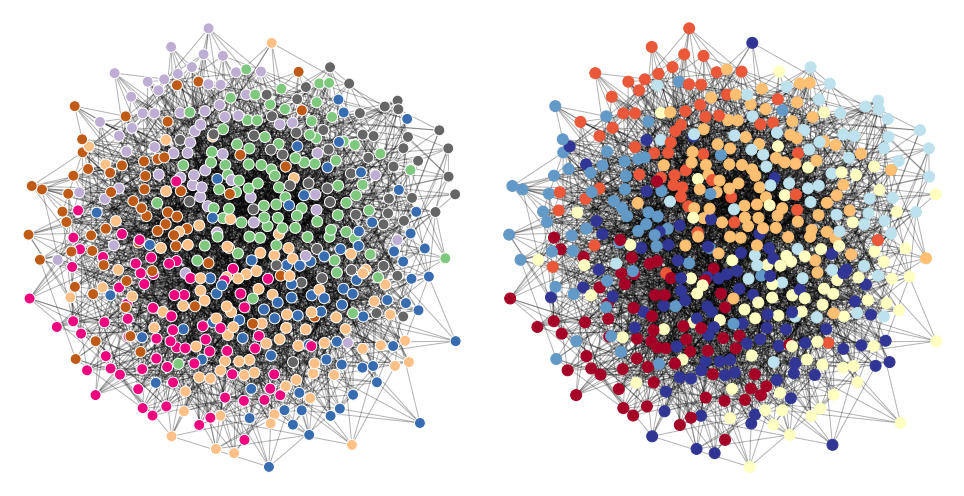

In [535]:
import networkx as nx
import community
import matplotlib.pyplot as plt

# G = nx.karate_club_graph()  # load a default graph
partition = community.best_partition(g)  # compute communities

pos = nx.spring_layout(g, iterations=1000)  # compute graph layout
plt.figure(figsize=(13.5, 7))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_nodes(g, pos, node_size=120, cmap='Accent', edgecolors='white', node_color=list(partition.values()))
nx.draw_networkx_edges(g, pos, alpha=0.3)

plt.subplot(122)
plt.axis('off')
nx.draw_networkx_nodes(g, pos, node_size=120, cmap='RdYlBu', node_color=list(partition_true.values()))
nx.draw_networkx_edges(g, pos, alpha=0.3)

plt.tight_layout()
plt.show()

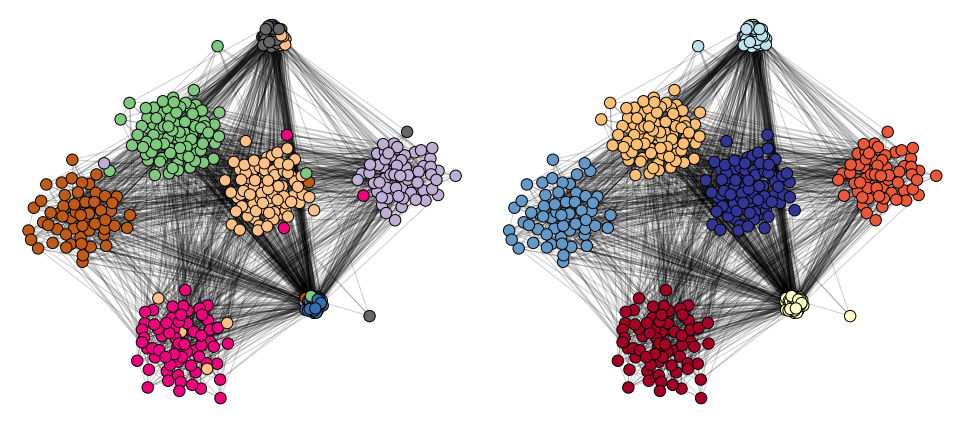

In [536]:
plot_graph()

In [542]:
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score

nmi = normalized_mutual_info_score(list(partition_true.values()), list(partition.values()))
ami = adjusted_mutual_info_score(list(partition_true.values()), list(partition.values()))

print('NMI: {:.4f}\nAMI: {:.4f}'.format(nmi, ami))

NMI: 0.8485
AMI: 0.8456


In [525]:
import numpy as np
import networkx as nx

import community
import matplotlib.pyplot as plt


def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def plot_graph():
    from community import community_louvain

    partition = community.best_partition(g)
    pos = community_layout(g, partition_true)

    plt.figure(figsize=(13.5, 6))

    plt.subplot(121)
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap='Accent', node_color=list(partition_true.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.2)

    plt.subplot(122)
    plt.axis('off')
    nx.draw_networkx_nodes(
        g, pos, node_size=130, edgecolors='k', cmap='Accent', node_color=list(partition.values()))
    nx.draw_networkx_edges(g, pos, alpha=0.2)

    plt.tight_layout()
    plt.show()
    
    return
